In [18]:
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import os
from sklearn.metrics import auc
from utils import get_percentile, import_graph

METRICS_LIST = ['degrees', 'k_cores', 'eccentricity', 'betweenness_centrality']
graph_names = ['wikivote', 'hamsterster', 'DCAM', 'gnutella', 'github', 'dblp2010']
method_names = ['RC','RW','BFS','DFS','MOD','DE']
METHOD_COLOR = {
    'AFD':'pink',
    'RC':'grey',
    'RW':'green',
    'DFS':'black', 
    'BFS':'blue', 
    'DE':'magenta', 
    'MOD':'red'
}

DUMPS_DIR = '../results/dumps_shared'
SEED_COUNT = 8
TOP_PERCENTILE = 10

Load results into memory

In [19]:
def load_results(base_dir, graph):
   
    file_pattern = graph + r'_results_budget(\d+).json'
    budget, filename = None, None
    
    for filename in os.listdir(base_dir):
        match = re.match(file_pattern, filename)
        if match:
            budget = int(match.group(1))
            break
            
    if not budget:
        raise FileNotFoundError
    
    with open(os.path.join(base_dir, filename), 'r') as result_file:
        data = json.load(result_file)
    return data['crawler_avg'], data['history'], int(budget)

In [20]:
# draw plot 

def draw_nodes_history(history, crawler_avg, print_methods, graph_name, seed_count, budget):
    """
    Drawing history for every method(average are bold) and every seed(thin)
    """
    # TBD - ,graph_name,seed_count are only for filenames. need to clean them
    plt.figure(figsize=(10, 10))
    plt.grid()
    
    auc_res = {}
    
    for method, method_data in history.items():
        if method in print_methods:
            auc_res[method] = {}
            for seed_num, seed_data in list(method_data.items())[:seed_count]:
                data = np.array(seed_data['nodes'][:budget])
                auc_res[method][seed_num] = auc(x=np.arange(len(data)), y=data)
                plt.plot(data,
                         linewidth=0.5,
                         color=METHOD_COLOR[method])

    for method, avg_data in crawler_avg.items():
        if method not in print_methods:
            continue
        data = np.array(avg_data['nodes'][:budget])
        auc_res[method]['average'] = auc(x=np.arange(len(data)), y=data)
        plt.plot(data,
                 linewidth=4,
                 color=METHOD_COLOR[method],
                 label=method)

    plt.legend()
    plt.savefig('../results/history/' + graph_name + '_history_' +
                str(seed_count) + '_seeds_' +
                str(budget) + 'iterations.png')
    plt.show()
    return auc_res
    
def draw_properties_history(percentile_set, crawler_avg, print_methods, graph_name, seed_count,
                            budget):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    plt.figure(figsize=(20, 20))
    
    auc_res = {}
    
    for method in print_methods:
        auc_res[method] = {}
        for prop in METRICS_LIST:
            # ремап для красивой отрисовки 2*2
            j = {'degrees': 0, 'k_cores': 1, 'eccentricity': 2, 'betweenness_centrality': 3}[prop] 
            
            data = np.array(crawler_avg[method][prop][:budget]) / seed_count / \
                   len(percentile_set[prop])
            auc_res[method][prop] = auc(x=np.arange(len(data)), y=data)
            axs[j // 2][j % 2].plot(data,
                                    label=method,
                                    color=METHOD_COLOR[method])
            axs[j // 2][j % 2].set_title(
                graph_name + '% nodes with ' + prop + ' from ' + str(len(percentile_set[prop])))
            axs[j // 2][j % 2].legend()

        axs[j // 2][j % 2].grid(True)
    fig.savefig('../results/history/' + graph_name + '_scores_' + 
                str(seed_count) + '_seeds_' + 
                str(budget) + 'iterations.png')
    plt.show()
    return auc_res

def plot_graph(graph_name, print_methods, budget_slices):
    crawler_avg, history, max_budget = load_results(DUMPS_DIR, graph_name)
    budget_slices.append(max_budget)
    
    big_graph = import_graph(graph_name)
    # берём топ 10 процентов вершин
    percentile, percentile_set = get_percentile(big_graph, graph_name, TOP_PERCENTILE)    
    
    if graph_name == 'gnutella': # большой костыль.Мы брали не тот эксцентриситет
        percentile_set['eccentricity'] = set(big_graph.nodes()).\
            difference(percentile_set['eccentricity'])
    
    for budget_slice in budget_slices:
        auc_res = draw_nodes_history(history, crawler_avg, print_methods, graph_name, SEED_COUNT, budget_slice)
        print('Nodes AUC for budget: '+ str(budget_slice) + ' ' + str(auc_res))
        
    auc_res = draw_properties_history(percentile_set, crawler_avg, print_methods, graph_name, SEED_COUNT,
                            max_budget)
    print('Properties AUC: ' + str(auc_res))

Wikivote nodes: 889 edges: 2914

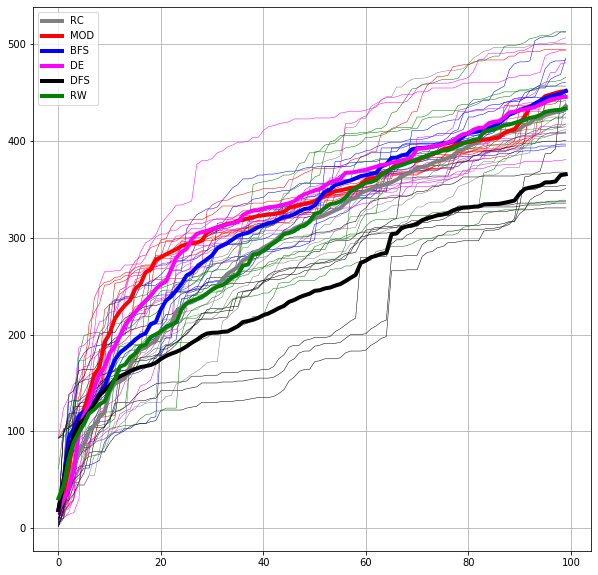

Nodes AUC for budget: 100 {'RC': {'398': 26637.0, '273': 31309.5, '378': 28045.5, '387': 29811.0, '417': 33728.5, '403': 25035.0, '766': 30380.0, '396': 28696.0, 'average': 29205.3125}, 'MOD': {'417': 31746.0, '766': 34627.5, '396': 31586.5, '378': 31330.0, '398': 32342.0, '273': 32117.0, '403': 31419.5, '387': 32200.0, 'average': 32171.0625}, 'BFS': {'417': 30240.5, '273': 32426.0, '398': 31295.0, '403': 33094.5, '387': 32470.5, '378': 29886.0, '766': 28059.5, '396': 33173.5, 'average': 31330.6875}, 'DE': {'398': 31958.0, '273': 33496.5, '766': 30049.5, '403': 33380.5, '396': 31495.0, '417': 30442.0, '387': 37577.0, '378': 29428.5, 'average': 32228.375}, 'DFS': {'387': 28543.0, '378': 25380.0, '766': 28634.5, '273': 25216.0, '417': 19243.5, '396': 20505.5, '403': 21420.5, '398': 25628.0, 'average': 24321.375}, 'RW': {'396': 32126.5, '273': 32457.5, '403': 26913.5, '417': 26941.0, '387': 34488.0, '398': 29173.5, '766': 23269.5, '378': 32406.0, 'average': 29721.9375}}
Nodes AUC for budg

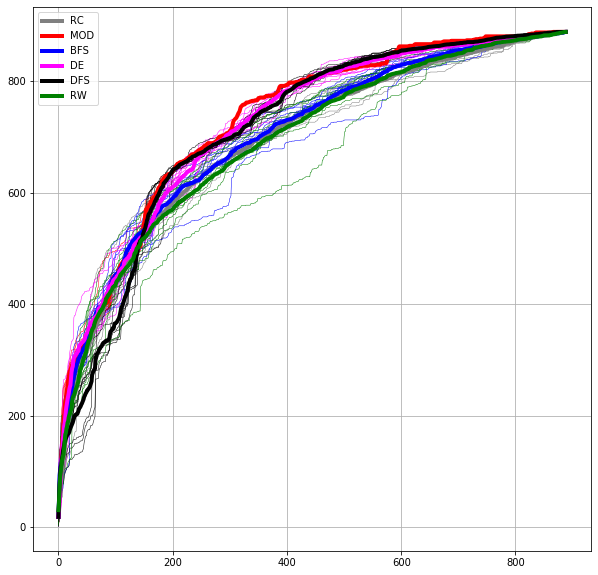

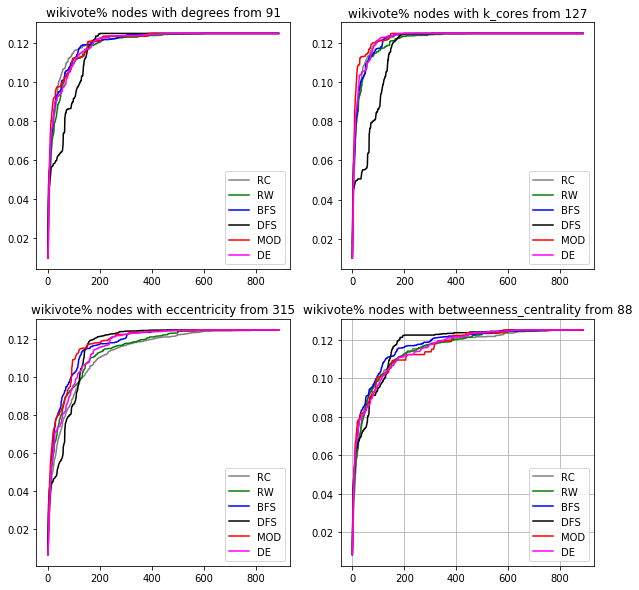

<Figure size 1440x1440 with 0 Axes>

In [21]:
plot_graph(graph_names[0], ['RC','RW','BFS','DFS','MOD','DE'], [100]) 

hamsterster nodes: 2000 edges: 16097

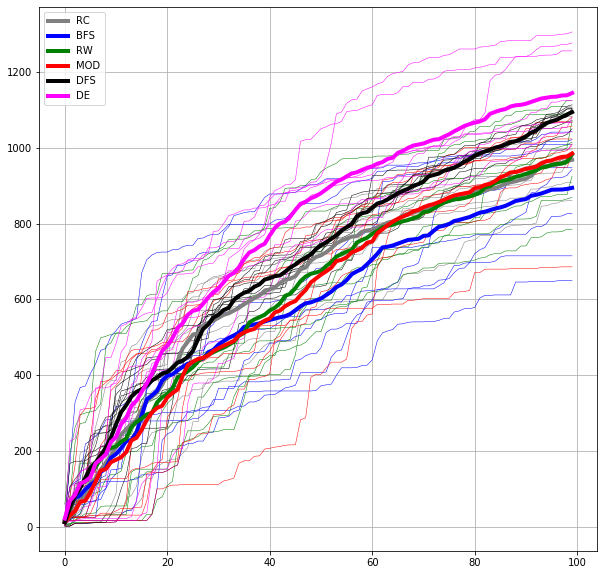

Nodes AUC for budget: 100 {'RC': {'1176': 66422.5, '425': 48181.0, '1562': 60076.0, '1995': 60076.5, '1581': 67645.5, '999': 73728.5, '835': 64017.0, '973': 68054.5, 'average': 63525.1875}, 'BFS': {'425': 37860.5, '835': 81304.5, '1176': 48713.0, '1562': 63910.0, '999': 51703.5, '1581': 51431.0, '973': 78296.5, '1995': 48347.0, 'average': 57695.75}, 'RW': {'973': 76056.0, '999': 56730.0, '1562': 62571.5, '425': 45474.5, '1581': 51286.0, '835': 82210.0, '1995': 51674.5, '1176': 64925.0, 'average': 61365.9375}, 'MOD': {'1562': 69159.0, '1995': 45760.5, '835': 73405.0, '425': 43141.5, '1176': 57466.0, '1581': 68776.0, '999': 53807.0, '973': 73788.5, 'average': 60662.9375}, 'DFS': {'1995': 69874.0, '835': 72922.5, '973': 70223.5, '1581': 69279.5, '1176': 68791.0, '425': 67491.0, '999': 70020.5, '1562': 60981.0, 'average': 68697.875}, 'DE': {'135': 77516.0, '1704': 62869.5, '864': 78811.5, '110': 73284.5, '1737': 85126.5, '40': 85809.5, '836': 82215.0, '1993': 66762.5, 'average': 76549.375}

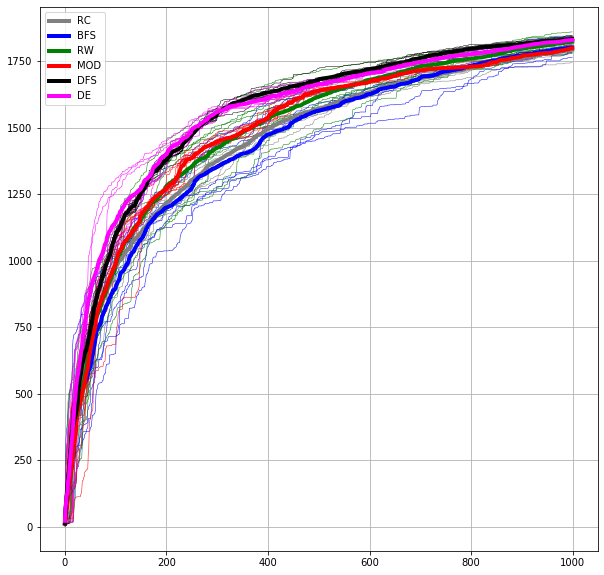

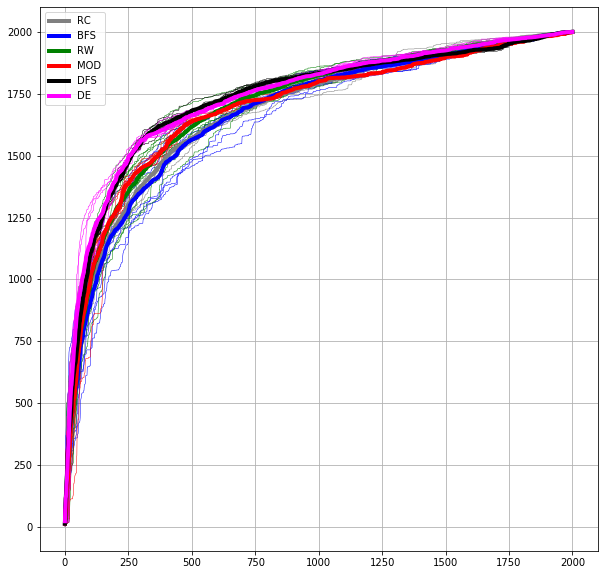

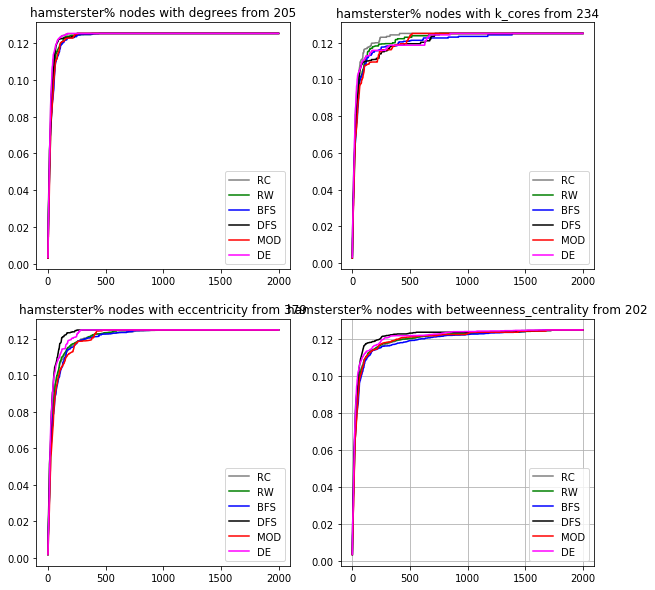

<Figure size 1440x1440 with 0 Axes>

In [22]:
plot_graph(graph_names[1], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000]) 

DCAM nodes: 2752 edges: 68741

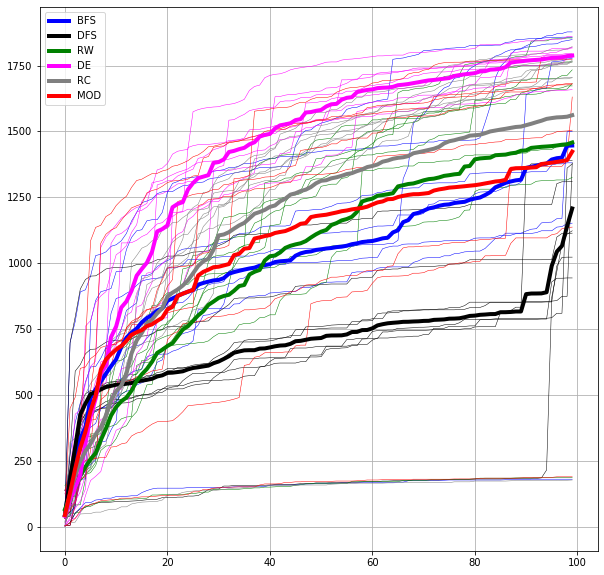

Nodes AUC for budget: 100 {'BFS': {'145391693': 119814.5, '131388': 99908.5, '979749': 90763.5, '229006675': 147984.5, '447189805': 134599.5, '20278562': 15188.0, '18770681': 110886.0, '2647636': 85777.0, 'average': 100615.1875}, 'DFS': {'447189805': 70001.0, '18770681': 71435.0, '229006675': 110647.5, '131388': 68601.0, '2647636': 64579.5, '20278562': 18567.5, '145391693': 87200.0, '979749': 64068.0, 'average': 69387.4375}, 'RW': {'18770681': 120325.5, '20278562': 14846.0, '447189805': 121724.0, '979749': 120289.5, '145391693': 96255.0, '2647636': 95933.0, '131388': 121358.5, '229006675': 119564.5, 'average': 101287.0}, 'DE': {'215761115': 138321.0, '37201652': 145755.0, '8544983': 142017.0, '59546961': 134497.5, '33110510': 155660.5, '192337300': 130989.5, '123068327': 132734.5, '135299200': 140122.5, 'average': 140012.1875}, 'RC': {'229006675': 128719.5, '447189805': 131065.0, '145391693': 131945.0, '2647636': 128161.5, '20278562': 14007.5, '979749': 129732.5, '131388': 131180.5, '1

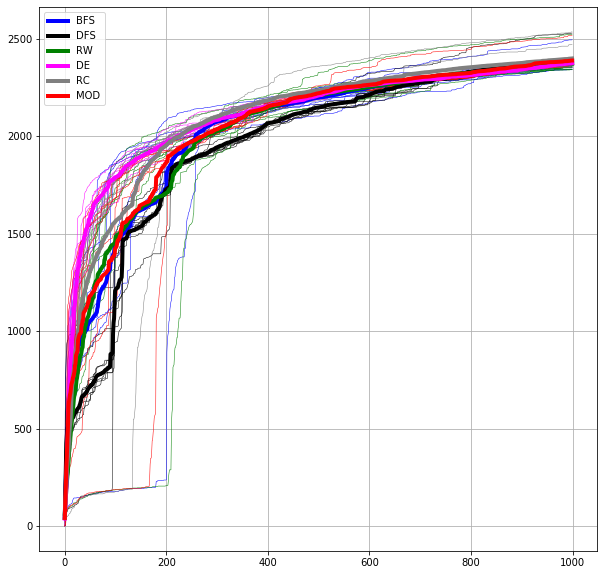

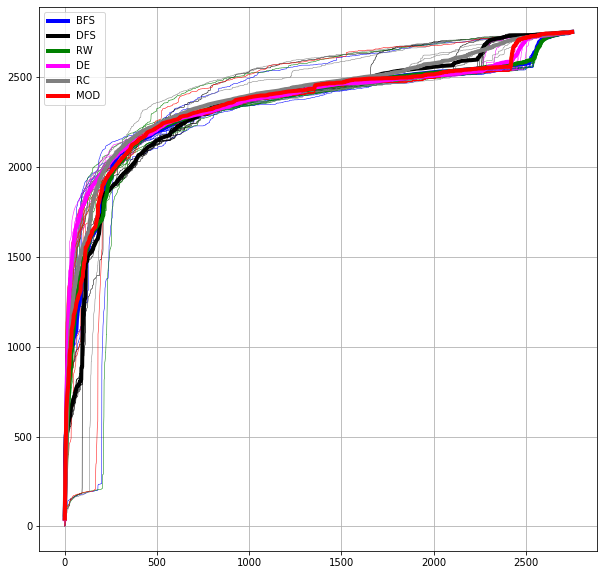

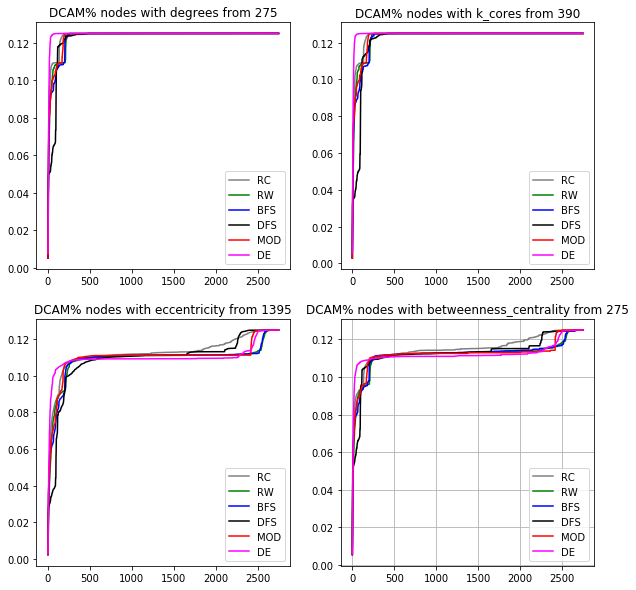

<Figure size 1440x1440 with 0 Axes>

In [23]:
plot_graph(graph_names[2], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000]) 

gnutella nodes: 36682 edges: 88328

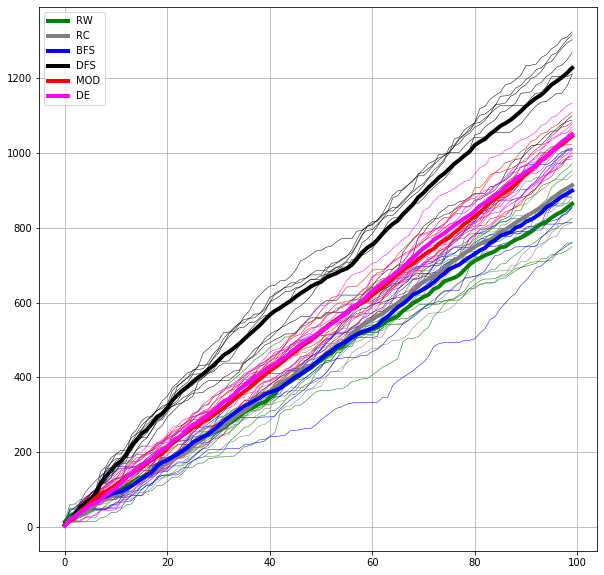

Nodes AUC for budget: 100 {'RW': {'31551': 40162.5, '34098': 35516.0, '27103': 44265.5, '897': 50707.0, '19469': 43940.5, '15290': 45182.5, '24157': 42045.5, '15410': 43489.5, 'average': 43163.625}, 'RC': {'34098': 37926.0, '24157': 50385.0, '897': 51051.0, '19469': 43885.0, '27103': 46813.0, '15290': 45999.0, '15410': 43495.0, '31551': 39768.5, 'average': 44915.3125}, 'BFS': {'18935': 43036.0, '427': 32032.5, '11970': 40338.5, '682': 48724.5, '18677': 48836.5, '15471': 48949.0, '20227': 45573.0, '12967': 48104.5, 'average': 44449.3125}, 'DFS': {'7653': 57444.5, '13386': 68274.5, '17990': 64532.0, '28829': 70152.0, '7833': 64211.0, '26847': 67343.5, '34822': 56447.0, '6955': 66666.0, 'average': 64383.8125}, 'MOD': {'34822': 48388.5, '6955': 54708.0, '13386': 55518.5, '28829': 52804.0, '26847': 46666.0, '7653': 50671.5, '17990': 50896.5, '7833': 50153.0, 'average': 51225.75}, 'DE': {'15161': 53268.5, '5440': 50671.5, '3161': 47373.5, '19100': 53790.5, '15853': 52625.0, '22902': 57386.0,

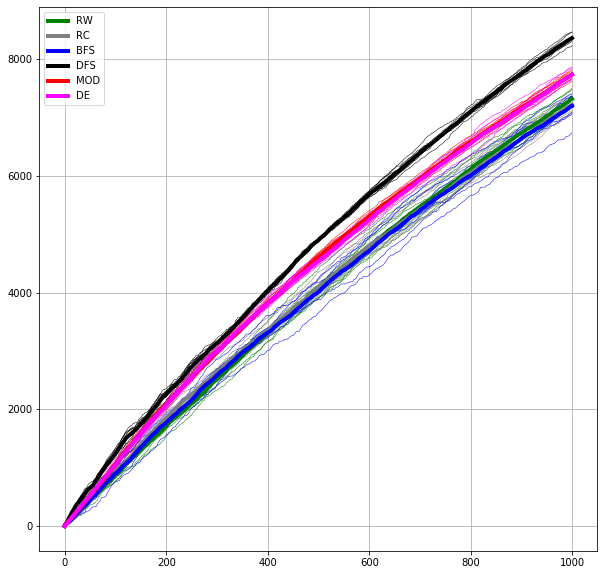

/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


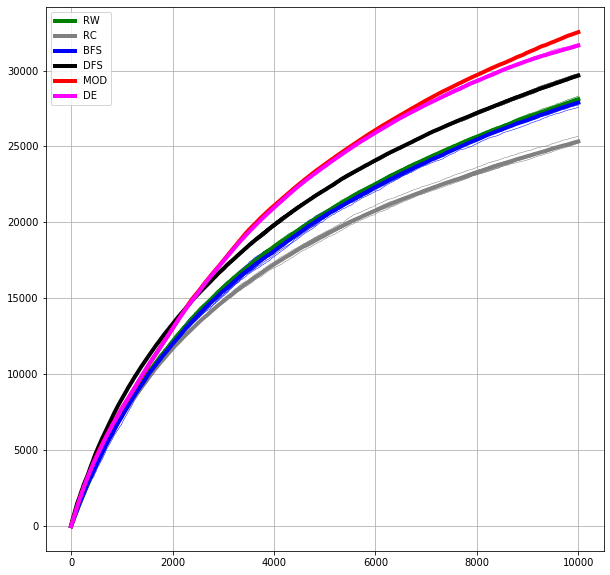

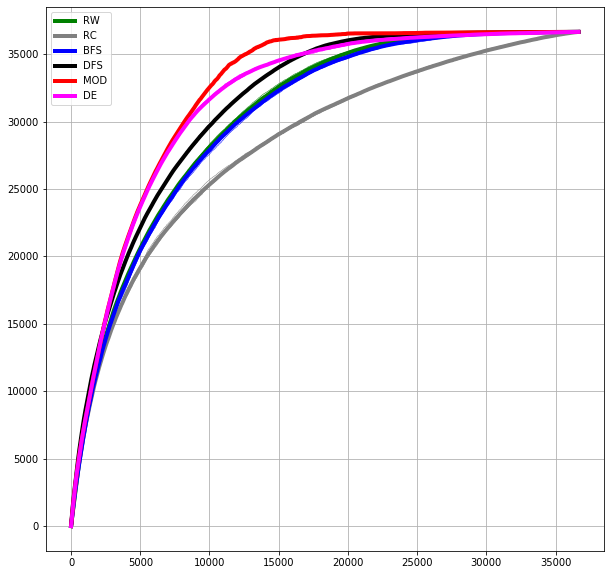

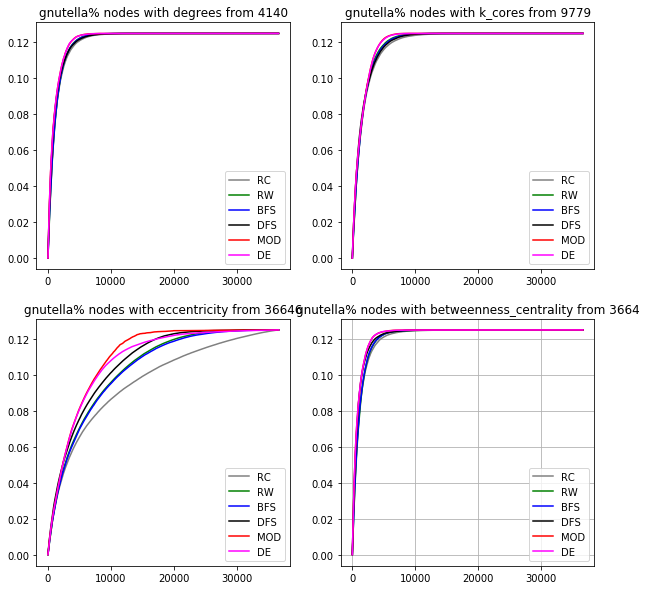

<Figure size 1440x1440 with 0 Axes>

In [24]:
plot_graph(graph_names[3], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000, 10000]) 

github nodes: 120865 edges: 439858

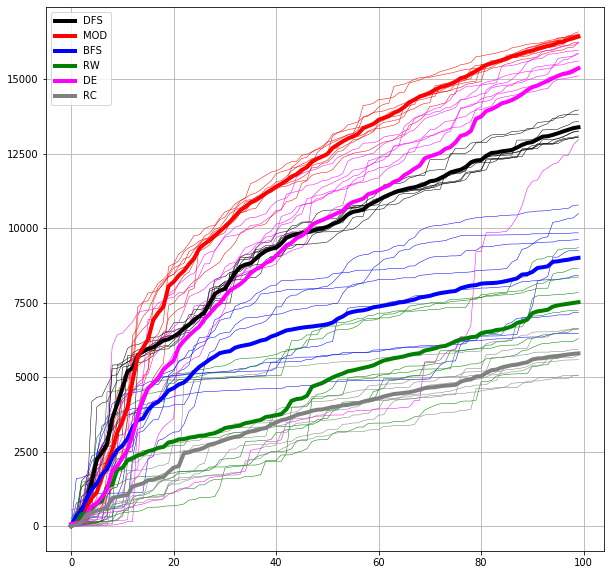

Nodes AUC for budget: 100 {'DFS': {'17161': 922373.5, '109528': 909040.5, '14272': 927897.5, '38075': 917882.0, '12741': 940535.0, '83843': 878244.5, '75352': 934284.0, '15640': 915681.0, 'average': 918242.25}, 'MOD': {'36983': 1108662.0, '49211': 1146501.0, '29633': 1116974.0, '73126': 1137478.5, '34745': 1131172.0, '69293': 1150594.5, '92222': 1119286.0, '51709': 1050290.5, 'average': 1120119.8125}, 'BFS': {'74040': 524659.5, '54556': 534416.5, '18850': 708060.0, '64502': 699583.5, '60730': 612469.5, '10581': 690812.5, '45841': 699677.0, '4454': 500598.5, 'average': 621284.625}, 'RW': {'49161': 337843.5, '50673': 603614.5, '63497': 370122.0, '20712': 584125.0, '94799': 411298.0, '30631': 279099.5, '89739': 377923.5, '11683': 608570.5, 'average': 446574.5625}, 'DE': {'112090': 1082675.5, '16026': 994499.5, '54105': 946947.0, '34132': 996347.0, '82146': 1082876.5, '24681': 441884.5, '38078': 967955.0, '32': 968276.5, 'average': 935182.6875}, 'RC': {'63497': 315753.0, '94799': 370634.5,

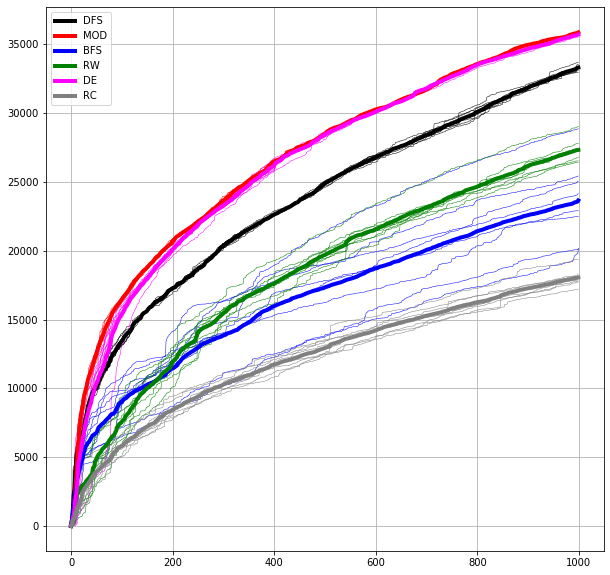

/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


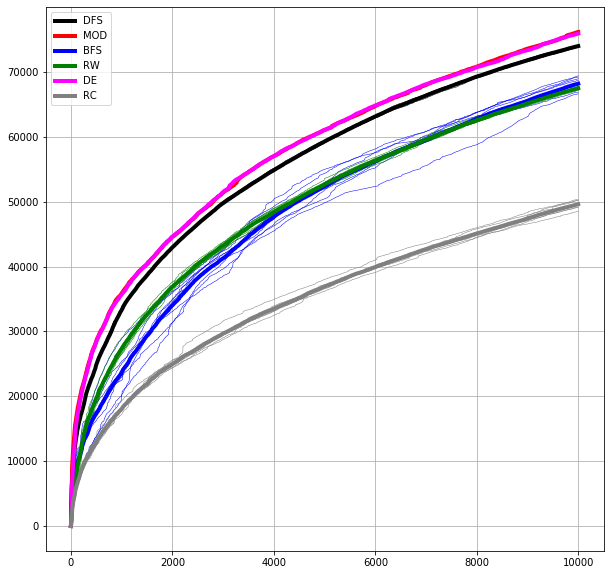

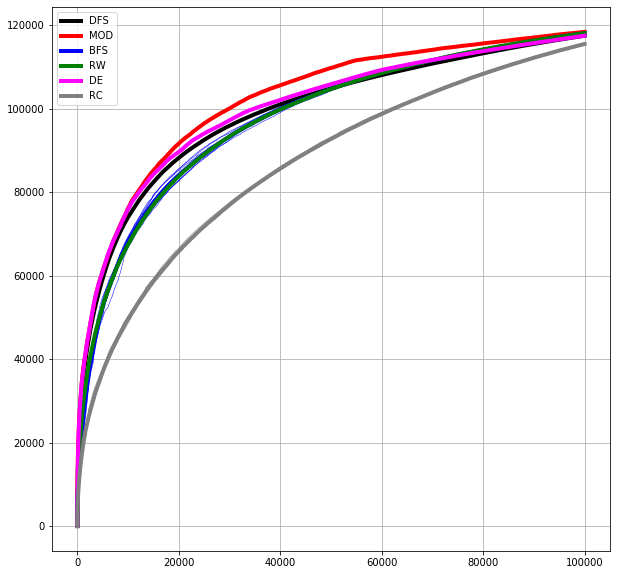

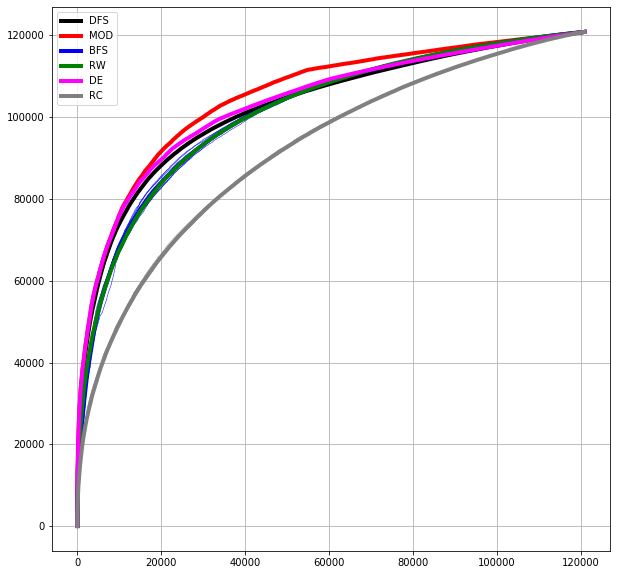

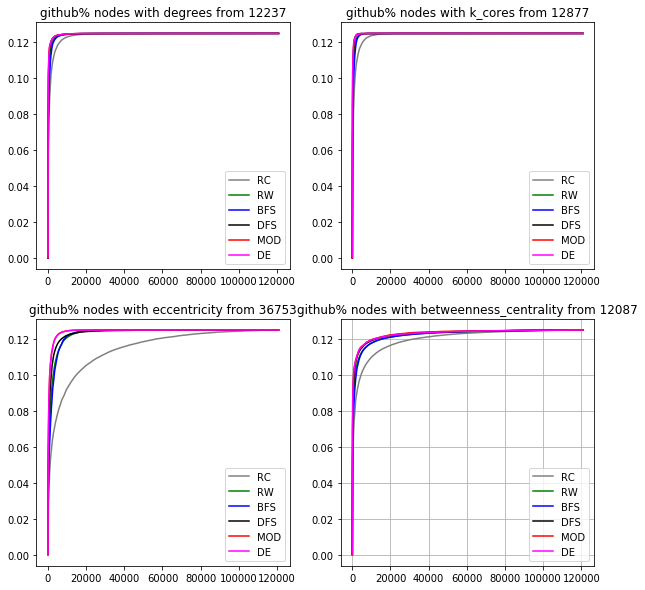

<Figure size 1440x1440 with 0 Axes>

In [25]:
plot_graph(graph_names[4], ['RC','RW','BFS','DFS','MOD','DE'], [100, 1000, 10000, 100000]) 
 

dblp2010 nodes: 226413 edges: 716460

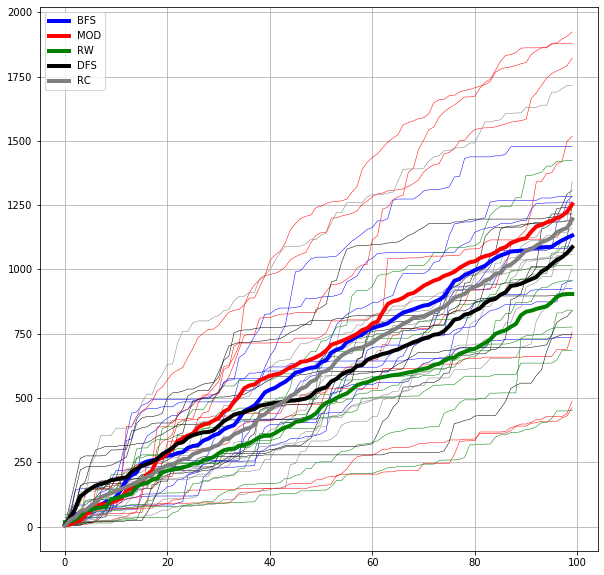

Nodes AUC for budget: 100 {'BFS': {'61813': 58910.5, '68604': 45974.0, '129709': 87661.5, '201477': 50976.0, '42339': 57992.5, '92396': 67275.5, '79557': 41166.0, '194214': 79398.5, 'average': 61169.3125}, 'MOD': {'224322': 111714.5, '46112': 71796.5, '152021': 95485.5, '82756': 21077.0, '109619': 19934.5, '26793': 56566.5, '192604': 96041.5, '135113': 46619.0, 'average': 64904.375}, 'RW': {'62723': 28169.0, '137884': 60564.5, '84472': 45037.0, '177513': 18421.0, '193812': 48057.5, '202991': 50486.5, '24063': 70775.0, '208525': 38342.0, 'average': 44981.5625}, 'DFS': {'107176': 51708.5, '79477': 30749.0, '220702': 72669.0, '5161': 62386.5, '142978': 43689.5, '28262': 59162.0, '94606': 82576.0, '23267': 39913.0, 'average': 55356.6875}, 'RC': {'218622': 56498.0, '185423': 63322.5, '4375': 56594.5, '67047': 34136.0, '84804': 57687.5, '106181': 40980.5, '16064': 46349.0, '152728': 105571.5, 'average': 57642.4375}}
Nodes AUC for budget: 1000 {'BFS': {'61813': 5395760.5, '68604': 5023210.5, 

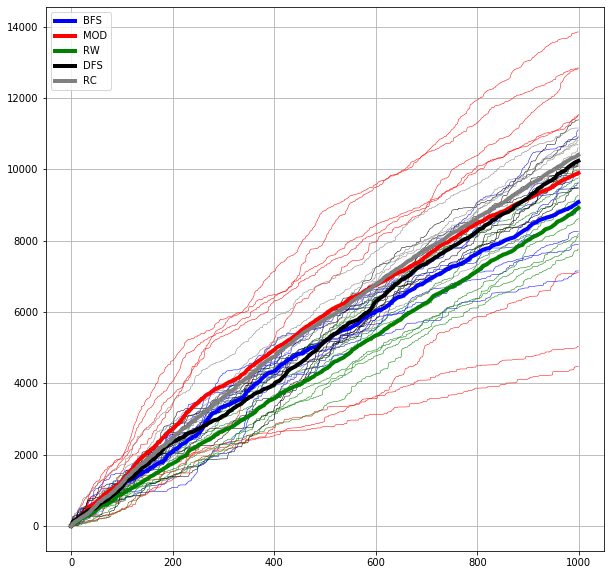

/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/yatskov/Documents/crawling/venv/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


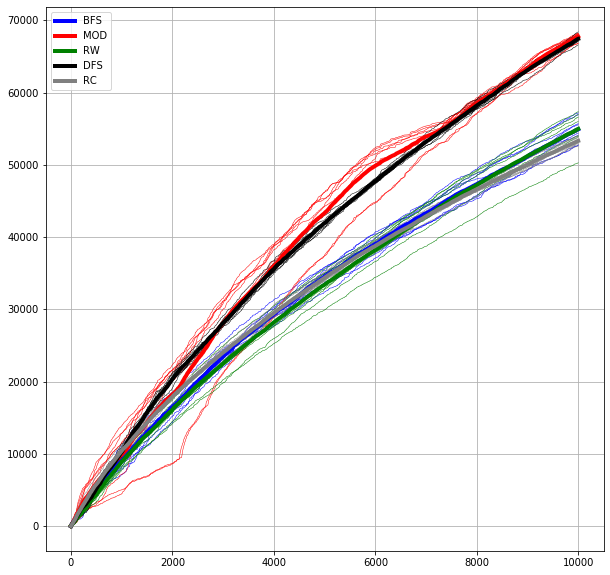

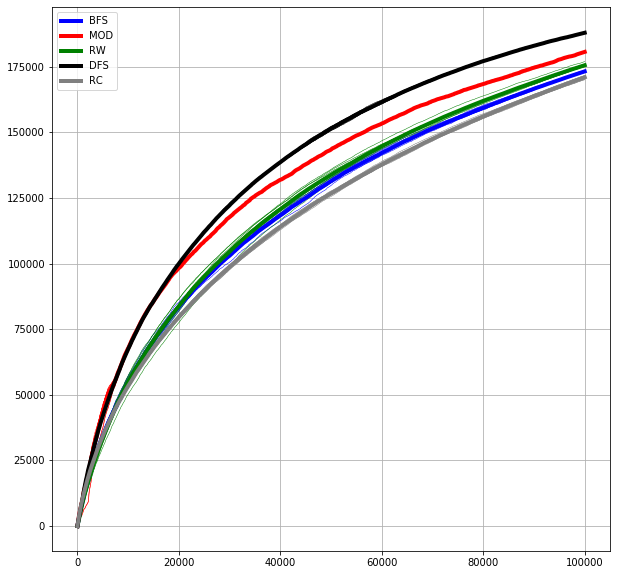

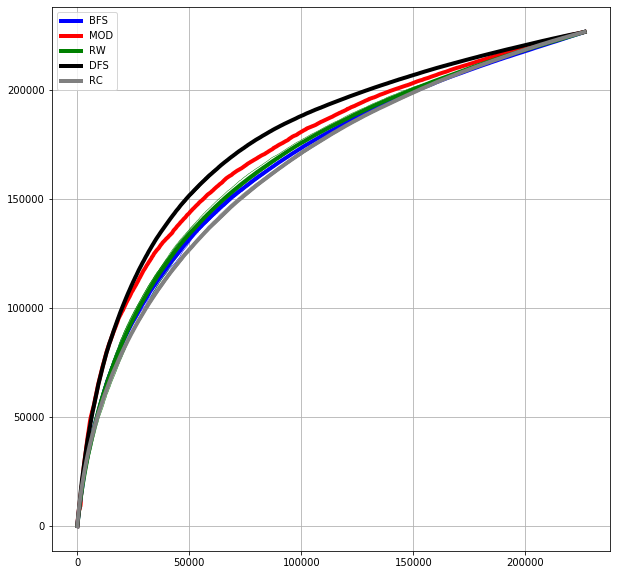

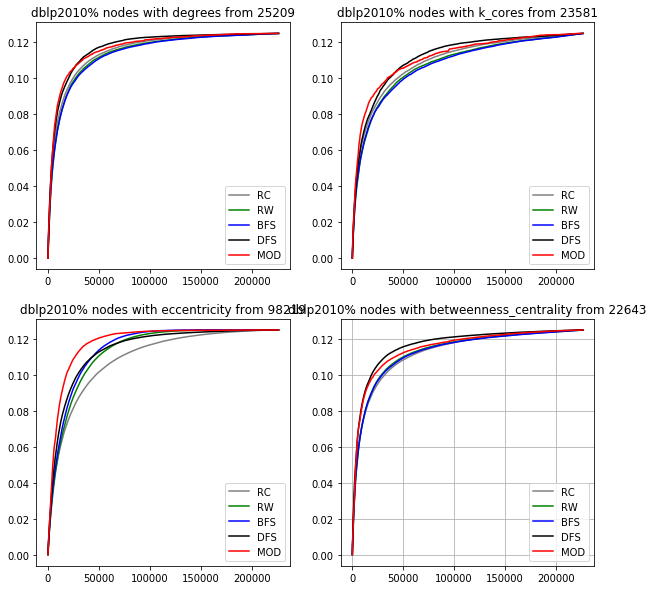

<Figure size 1440x1440 with 0 Axes>

In [26]:
plot_graph(graph_names[5], ['RC','RW','BFS','DFS','MOD'], [100, 1000, 10000, 100000]) 